In [1]:
cd("..")
include("full_scene.jl")
"done"

    .-(AbstractArray, Union{DataArrays.DataArray, DataArrays.PooledDataArray}) at /home/tim/.julia/v0.4/DataArrays/src/broadcast.jl:285
is ambiguous with: 
    .-(Images.AbstractImageDirect, AbstractArray) at /home/tim/.julia/v0.4/Images/src/algorithms.jl:40.
To fix, define 
    .-(Images.AbstractImageDirect, Union{DataArrays.DataArray, DataArrays.PooledDataArray})
before the new definition.
    .==(AbstractArray{Bool, N<:Any}, Union{DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}, DataArrays.DataArray{Bool, N<:Any}}) at /home/tim/.julia/v0.4/DataArrays/src/broadcast.jl:330
is ambiguous with: 
    .==(Images.AbstractImageDirect{Bool, N<:Any}, AbstractArray{Bool, N<:Any}) at /home/tim/.julia/v0.4/Images/src/algorithms.jl:181.
To fix, define 
    .==(Images.AbstractImageDirect{Bool, N<:Any}, Union{DataArrays.PooledDataArray{Bool, R<:Integer, N<:Any}, DataArrays.DataArray{Bool, N<:Any}})
before the new definition.
    .==(AbstractArray, Union{DataArrays.DataArray, DataArrays.PooledDa

"done"

# Load Dataset

In [2]:
include("full_scene.jl")

tic()
dsetexp = JLD.load("output/dsetexport.jld", "dsetexp")
toc()

println("nscenes: ", length(dsetexp.scenes))
println("nvehstates: ", length(dsetexp.states))
println("ave veh / scene: ", length(dsetexp.states)/length(dsetexp.scenes))

tic()
dset = reconstruct_dataset(dsetexp, create_core_factors())
toc()

get_dset_bounds(dset::SceneDataset)

"done"

elapsed time: 4.432774975 seconds
nscenes: 3977
nvehstates: 87201
ave veh / scene: 21.926326376665827
elapsed time: 

1.377144545 seconds
v:       0.000      94.827      30.287      14.071
t:     -16.562      11.889      -0.258       1.648
ϕ:      -0.335       0.398      -0.001       0.020
Δd:      0.066     276.738      50.078      31.167
Δv:    -44.259      56.623       0.321       4.811
T:       0.046      10.000       1.373       0.466


"done"

# Load Model

In [3]:
model_file = get_most_resent_file("output")
saved_model = JLD.load(model_file)
println("save time: ", saved_model["time"])

factors = create_core_factors()
set_weights!(factors, saved_model["weights"])
println("DONE")

save time: 2016-06-08T14:28:16
DONE


# Simulation

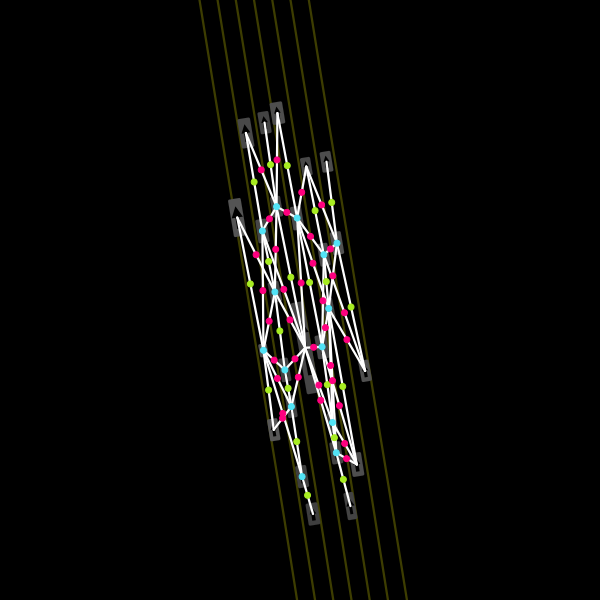

In [4]:
scene_index = 1000
proposal_distribution = MvNormal([2.0, 0.5, 1.0, 0.01]) # s, t, v, theta standard deviations

scene, structure = get_scene_and_structure(dset, scene_index)
scene_source = dset.sources[scene_index]
extractor = deepcopy(scene)
n_steps = 5

metropolis_hastings!(extractor, structure, factors, proposal_distribution, n_steps)
render_scene!(extractor, structure, camerazoom=1.5)

# Model Training

In [6]:
include("full_scene.jl")
srand(1)
model = IntelligentDriverModel(σ₁=0.1,σ₂=0.01)
transition = MvNormal([2.0, 0.5, 1.0, 0.01]) # s, t, v, theta standard deviations
nsteps_burnin = 100
direct = SamplingParams2(factors, transition, nsteps_burnin, dset, Scene())
simparams = SimParams()
ds = DirectPropSampling(direct, model, simparams)
tic()
solve!(ds, 1000)
toc()
mean(ds)

elapsed time: 19.371292745 seconds


0.02899999999999999

In [8]:
include("full_scene.jl")
srand(1)
empty!(ds)
tic()
f_true = mean(solve!(ds, round(Int, 10^5)))
toc()
f_true

elapsed time: 1857.411241446 seconds


0.028459999999999968

In [ ]:
include("full_scene.jl")

arr_nsamples = round(Int, logspace(2.0, 3.0, 21))
is = ImportancePropSampling(ds.sampler, ds.driver, ds.simparams, maximum(arr_nsamples))

f_true = 0.03
tic()
ax = plot_convergence([ds, is], f_true, arr_nsamples=arr_nsamples)
toc()
# PGFPlots.save("convergence_sample_and_prop.tex", ax)
ax